In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import torch
from tqdm import tnrange

sys.path.insert(0, '..')
from adaptis.inference.adaptis_sampling import get_panoptic_segmentation
from adaptis.inference.prediction_model import AdaptISPrediction

device = torch.device('cuda:1')

### Init dataset

In [23]:
from adaptis.data.robotec import RobotecDataset

dataset_path = '../../custom_dataset/'
dataset = RobotecDataset(dataset_path, split='test', with_segmentation=True, get_image_scale=0.6)

### Load model

In [24]:
from adaptis.model.robotec.models import get_unet_model

num_classes = 6

model = get_unet_model(num_classes=num_classes, norm_layer=torch.nn.BatchNorm2d, with_proposals=True)
pmodel = AdaptISPrediction(model, dataset, device)

weights_path = '../experiments/robotec/035_final_60/checkpoints/proposals_last_checkpoint.params'
pmodel.load_parameters(weights_path)

### Define evaluation function

In [25]:
from adaptis.coco.panoptic_metric import PQStat, pq_compute, print_pq_stat


def test_model(pmodel, dataset,
               sampling_algorithm, sampling_params,
               use_flip=False, cut_radius=-1):
    pq_stat = PQStat()
    categories = dataset._generate_coco_categories()
    categories = {x['id']: x for x in categories}

    for indx in tnrange(len(dataset)):
        sample = dataset.get_sample(indx)
        pred = get_panoptic_segmentation(pmodel, sample['image'],
                                         sampling_algorithm=sampling_algorithm,
                                         use_flip=use_flip, cut_radius=cut_radius, **sampling_params)
        
        
        coco_sample = dataset.convert_to_coco_format(sample)
        pred = dataset.convert_to_coco_format(pred)

        pq_stat = pq_compute(pq_stat, pred, coco_sample, categories)
    
    print_pq_stat(pq_stat, categories)

### Test proposals-based point sampling

In [26]:
proposals_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 100
}

test_model(pmodel, dataset,
           sampling_algorithm='proposals',
           sampling_params=proposals_sampling_params,
           use_flip=False)

/tmp/ipykernel_528500/3711189657.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for indx in tnrange(len(dataset)):


  0%|          | 0/90 [00:00<?, ?it/s]

          |     PQ      SQ      RQ     N
--------------------------------------
All       |  26.05   64.66   29.45     6
Things    |  11.37   57.70   15.34     5
Stuff     |  99.48   99.48  100.00     1


In [27]:
proposals_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 100
}

test_model(pmodel, dataset,
           sampling_algorithm='proposals',
           sampling_params=proposals_sampling_params,
           use_flip=True)

/tmp/ipykernel_528500/3711189657.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for indx in tnrange(len(dataset)):


  0%|          | 0/90 [00:00<?, ?it/s]

          |     PQ      SQ      RQ     N
--------------------------------------
All       |  25.08   63.17   28.57     6
Things    |  10.23   55.93   14.28     5
Stuff     |  99.37   99.37  100.00     1


### Test random sampling

In [28]:
random_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'num_candidates': 7,
    'num_iters': 40
}

test_model(pmodel, dataset,
           sampling_algorithm='random', sampling_params=random_sampling_params,
           use_flip=False)

/tmp/ipykernel_528500/3711189657.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for indx in tnrange(len(dataset)):


  0%|          | 0/90 [00:00<?, ?it/s]

          |     PQ      SQ      RQ     N
--------------------------------------
All       |  28.31   64.18   32.59     6
Things    |  14.07   57.12   19.11     5
Stuff     |  99.50   99.50  100.00     1


In [29]:
random_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'num_candidates': 7,
    'num_iters': 40
}

test_model(pmodel, dataset,
           sampling_algorithm='random', sampling_params=random_sampling_params,
           use_flip=True)

/tmp/ipykernel_528500/3711189657.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for indx in tnrange(len(dataset)):


  0%|          | 0/90 [00:00<?, ?it/s]

          |     PQ      SQ      RQ     N
--------------------------------------
All       |  28.07   63.72   32.31     6
Things    |  13.80   56.59   18.77     5
Stuff     |  99.39   99.39  100.00     1


### Results visualization

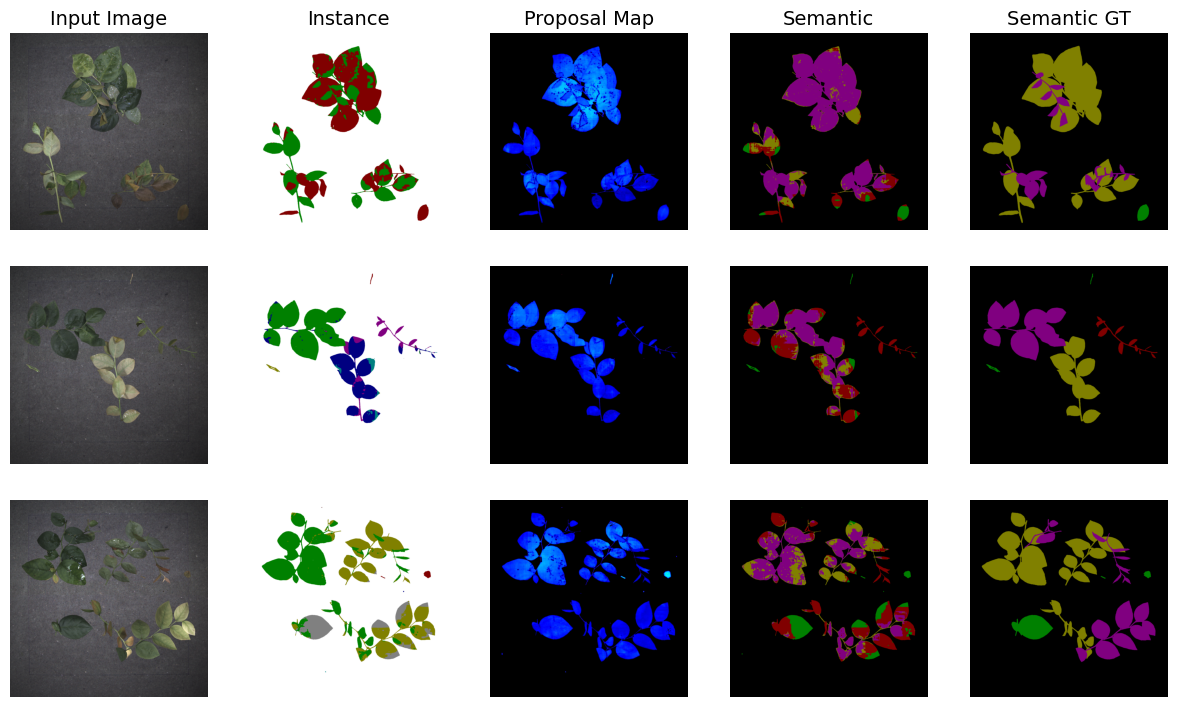

In [31]:
from adaptis.utils.vis import visualize_instances, visualize_proposals, visualize_mask


proposals_sampling_params = {
    'thresh1': 0.5,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 100
}

vis_samples = [15, 26, 42]


fig, ax = plt.subplots(nrows=len(vis_samples), ncols=5, figsize=(12,7))
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

for row_indx, sample_indx in enumerate(vis_samples):
    sample = dataset.get_sample(sample_indx)
    pred = get_panoptic_segmentation(pmodel, sample['image'],
                                 sampling_algorithm='proposals',
                                 use_flip=True, **proposals_sampling_params)
    
    for i in range(5):
        ax[row_indx, i].axis('off')

    if row_indx == 0:
        ax[row_indx, 0].set_title('Input Image', fontsize=14)
        ax[row_indx, 1].set_title('Instance', fontsize=14)
        ax[row_indx, 2].set_title('Proposal Map', fontsize=14)
        ax[row_indx, 3].set_title('Semantic', fontsize=14)
        ax[row_indx, 4].set_title('Semantic GT', fontsize=14)
    ax[row_indx, 0].imshow(sample['image'])
    ax[row_indx, 1].imshow(visualize_instances(pred['instances_mask']))
    ax[row_indx, 2].imshow(visualize_proposals(pred['proposals_info']))
    ax[row_indx, 3].imshow(visualize_mask(pred['semantic_segmentation'], 6))
    ax[row_indx, 4].imshow(visualize_mask(sample['semantic_segmentation'], 6))
    